In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import floor
from tqdm import tqdm

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE, roc_auc_score as AUC_score
from sklearn import preprocessing

from neural_network import NeuralNetwork as NeuralNetwork_module
from classification_problem import Classification

mpl.rcdefaults()
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

In [3]:
class NeuralNetwork:

    def __init__(
            self,
            X_data,
            Y_data,
            problem,    # input problem class, containing activiation functions and cost functions
            n_hidden_neurons_list =[2],    # list with numbers of neurons in each layer
            n_output_neurons=10,    # nr neurons output layer
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            debug=False):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_layers = len(n_hidden_neurons_list)
        self.n_hidden_neurons_list = n_hidden_neurons_list
        self.n_output_neurons = n_output_neurons

        self.Problem = problem
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        self.debug = debug
        self.accuracy_each_epoch_train = np.zeros(epochs)
        self.accuracy_each_epoch_test = np.zeros(epochs)
        self.area_under_curve_train = np.zeros(epochs)
        self.area_under_curve_test = np.zeros(epochs)

        self.initialize_layers()

    def initialize_layers(self):
        """ Initializes the weights and biases for the hidden layers and output layer """
        n_hidden = self.n_hidden_neurons_list
        
        # Bias of layers l = [1,L-1]:
        self.bias_list = [np.zeros(n)+0.01 for n in n_hidden]
        # appending output layer:
        self.bias_list.append(np.zeros(self.n_output_neurons)+0.01)
        
        # Weights for l = [1,L-1]:
        self.weights_list = [np.random.randn(self.n_features,n_hidden[0])]    # From input to l=1
        # Dimension of layers l dependenent on layer l-1:
        for i in range(1,self.n_layers):
            self.weights_list.append(np.random.randn(n_hidden[i-1],n_hidden[i]))
        # appending output layer:
        self.weights_list.append(np.random.randn(n_hidden[-1], self.n_output_neurons))
    
    def printshape(self,x,name='x'):
        """ Helper function for debugging, printing shapes of variable x """
        if isinstance(x,list):
            x = np.array(x)
        if self.debug:
            print('shape '+name,x.shape)
            
    def feed_forward(self):
        """
        Feed forward loop used in training, looping all hidden layers and
        produces output probabilities for use in back propagation in last element of a
        """
        problem = self.Problem
        # Input, Not using weights and biases for input layer
        self.a_list = [self.X_data]
        self.z_list = []
        
        # Loop through the layers, store weighted sum and activations
        for w,b in zip(self.weights_list,self.bias_list):
            
            self.z_list.append(np.matmul(self.a_list[-1],w)+b)
            self.a_list.append(problem.hidden_activation(self.z_list[-1]))
            
        # Overwrite the last entry in a_list to use the output activation function
        self.a_list[-1] = problem.output_activation(self.z_list[-1])

    def feed_forward_out(self, X):
        problem = self.Problem
        # Input, Not using weights and biases for input layer
        a_list = [X]
        z_list = []

        for w,b in zip(self.weights_list,self.bias_list):
            z_list.append(np.matmul(a_list[-1],w)+b)
            a_list.append(problem.hidden_activation(z_list[-1]))

        # Overwrite last entry:
        a_list[-1] = problem.output_activation(z_list[-1])
        return a_list[-1]

    def backpropagation(self):
        """
        Performs the back propagation algorithm, with output from forward pass
        in self.probabilities. Uses the expressions from the given Problem class
        to compute the output error.
        """
        problem = self.Problem
        
        ## First find errors from each layer: ##
        ## ---------------------------------- ##
        error_list = []
        grad_w_list = []
        grad_b_list = []
        
        # Finds the output error (delta^L) using the given cost function from Problem
        output_error = problem.output_error(self.a_list[-1],self.Y_data)
        error_list.append(output_error)
        
        # Propagate error back in the hidden layers to find error from each layer
        # (usually not so high nr of layers, so looping 2 times for easy implementation. Once for finding errors and once for applying them)
        L = self.n_layers   # last layer number
        
        for l in range(2,L+2): 
            prev_error = error_list[-1]
            prev_w = self.weights_list[-l+1]
            current_z = self.z_list[-l]
            error_hidden = np.matmul(prev_error,prev_w.T)*problem.hidden_activation(current_z,prime=True)  # CHECK ORDER IN MATMUL?
            error_list.append(error_hidden)

        # Error_list is optained backwards, reverting to match layer numbers better, but note there is no error for input layer
        error_list.reverse()

        ## Find gradients from each layer: ##
        ## ------------------------------- ##
        # Looping over all layers
        for l in range(L+1):
            
            # Finding gradients
            grad_b_list.append(np.sum(error_list[l],axis=0))
            # Note that the index for a_list in the following seem to be wrong, but it is not.
            # In the equations we have a[l-1] and delta [l], the way the error is calculated 
            # the indices of a_list and error_list are scewed once relative to each other!
            grad_w_list.append(np.matmul(self.a_list[l].T,error_list[l]))

            if self.lmbd > 0.0: # If using regularization
                grad_w_list[l] += self.lmbd * self.weights_list[l]
            
            # Update weights and biases
            self.weights_list[l] -= self.eta*grad_w_list[l]
            self.bias_list[l] -= self.eta*grad_b_list[l]
        
    def get_prediction(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def get_predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def SGD(self):
        """
        Perform a stochastic gradient descent algorithm, looping over epochs and saturating each minibatch
        Stores accuracy and area under curve score after each epoch, to vizualise the learning rate
        """
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()
            
            # Storing scores during the epochs
            pred_test = self.get_predict_probabilities(X_test_scaled)
            pred_train = self.get_predict_probabilities(X_train_scaled)
            self.accuracy_each_epoch_test[i] = accuracy_score(from_one_hot(Y_test),np.argmax(pred_test,axis=1))
            self.accuracy_each_epoch_train[i] = accuracy_score(from_one_hot(self.Y_data_full),np.argmax(pred_train,axis=1))
            self.area_under_curve_test[i] = AUC_score(Y_test,pred_test)
            self.area_under_curve_train[i] = AUC_score(Y_train,pred_train)


In [4]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

def to_one_hot(category_array):
    ca = category_array # 1D array with values of the categories
    nr_categories = np.max(ca)+1
    nr_points = len(ca)
    one_hot = np.zeros((nr_points,nr_categories),dtype=int)
    one_hot[range(nr_points),ca] = 1
    return one_hot

def from_one_hot(one_hot_array):
    category_arr = np.nonzero(one_hot_array)[1]
    return category_arr

# Classification

In [5]:
data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")
data = data_pd.to_numpy()
output = data[:,-1]
input_data = data[:,:-1]
print(output.shape, input_data.shape)
output_one_hot = to_one_hot(output)

(21308,) (21308, 23)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_one_hot)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [7]:
hidden_neuron_list = [16,16]
AUC = []
accuracy = []
epochs = 100
runs = 10
acc_test = np.zeros((runs,epochs))
acc_train = np.zeros((runs,epochs))
clf = Classification()

for i in tqdm(range(runs)):
    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_one_hot,test_size=0.3)
    Scaler = preprocessing.StandardScaler()
    X_train_scaled = Scaler.fit_transform(X_train)
    X_test_scaled = Scaler.transform(X_test)
    nn = NeuralNetwork( X_train_scaled,
                        Y_train,
                        problem = clf,
                        n_hidden_neurons_list=hidden_neuron_list,
                        n_output_neurons=2,
                        epochs=epochs,
                        batch_size=256,
                        eta=1e-3,
                        lmbd=1.67,
                        debug=True)
    nn.SGD()
    AUC.append(nn.area_under_curve_test[-1])
    accuracy.append(nn.accuracy_each_epoch_test[-1])
    acc_test[i,:] = nn.accuracy_each_epoch_test
    acc_train[i,:] = nn.accuracy_each_epoch_train

AUC_mean = np.mean(AUC)
accuracy_mean = np.mean(accuracy)
print('AUC mean = ',AUC_mean, ' accuracy mean = ',accuracy_mean)

100%|██████████| 10/10 [01:16<00:00,  7.81s/it]

AUC mean =  0.7753060503219796  accuracy mean =  0.7995933051775379


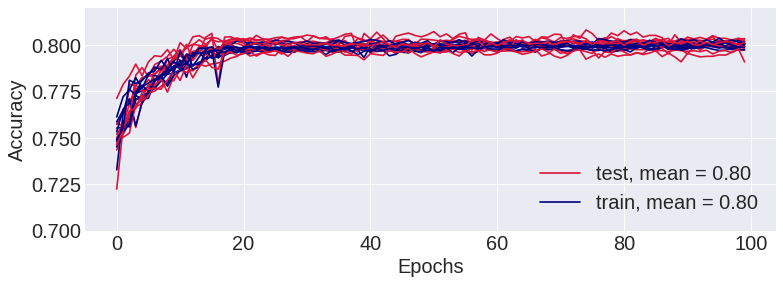

In [14]:
fig,ax = plt.subplots()

for i in range(len(acc_test)):
    ax.plot(acc_test[i],color='crimson',label='test, mean = {:.2f}'.format(np.mean(acc_test[:,-1])))
    ax.plot(acc_train[i],color='navy',label='train, mean = {:.2f}'.format(np.mean(acc_test[:,-1])))
    if i == 0:
        ax.legend(loc=4)
        ax.set_ylim(0.7,0.82)
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        plt.tight_layout()
fig.savefig('../figs/cc_epochs_self.pdf',bbox_inches='tight')

# Run 2

In [8]:
hidden_neuron_list = [16,16]
AUC = []
accuracy = []
epochs = 100
runs = 1
acc_test = np.zeros((runs,epochs))
acc_train = np.zeros((runs,epochs))
clf = Classification()

for i in tqdm(range(runs)):
    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_one_hot,test_size=0.1)
    Scaler = preprocessing.StandardScaler()
    X_train_scaled = Scaler.fit_transform(X_train)
    X_test_scaled = Scaler.transform(X_test)
    nn = NeuralNetwork_module( X_train_scaled,
                        Y_train,
                        problem = clf,
                        n_hidden_neurons_list=hidden_neuron_list,
                        n_output_neurons=2,
                        epochs=epochs,
                        batch_size=256,
                        eta=1e-3,
                        lmbd=1.67,
                        debug=False)
    nn.SGD(track='accuracy',test_data=(X_test,Y_test),train_data=(X_train_scaled,Y_train),one_hot_encoding=True)
    AUC.append(nn.area_under_curve_test[-1])
    accuracy.append(nn.accuracy_each_epoch_test[-1])
    acc_test[i,:] = nn.accuracy_each_epoch_test
    acc_train[i,:] = nn.accuracy_each_epoch_train

AUC_mean = np.mean(AUC)
accuracy_mean = np.mean(accuracy)
print('AUC mean = ',AUC_mean, ' accuracy mean = ',accuracy_mean)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/jakobs/Documents/UiO/FYS-STK4155/FYS-STK4155/Project2/src/classification_problem.py:80: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z)
/Users/jakobs/Documents/UiO/FYS-STK4155/FYS-STK4155/Project2/src/classification_problem.py:81: RuntimeWarning: invalid value encountered in true_divide
  return exp_term/np.sum(exp_term, axis=1, keepdims=True)
  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 